In [1]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

/Users/divyasankar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training Data

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [69]:
len(train_df['ImageId'].unique())

6666

In [3]:
files = os.listdir("train_images")   

In [97]:
num_classes = 4

Forming the golden output for each class by expanding the target based on the classId. Every image has 4 entries and only the image with defect class has the corresponding encoding pixels, other encoding pixels are filled with Nan.

In [5]:
trset_df = pd.DataFrame(index=range(0,4*len(files)), columns = ['ImageId','ClassId', 'EncodedPixels'])
trcount_df = pd.DataFrame(index=range(0,len(files)), columns = ['ImageId','Count'])
i = 0
for f in files:   
    myCount = 0
    for j in range(1,num_classes+1):
        idx = i * num_classes + j - 1
        myDf = train_df.loc[(train_df['ImageId'] == f) & (train_df['ClassId'] == j)]
        if myDf.shape[0] == 0:
            trset_df.iloc[idx] = pd.Series({'ImageId':f, 'ClassId':j})
        else:
            trset_df.iloc[idx] = pd.Series({'ImageId':f, 'ClassId':j, 'EncodedPixels': myDf.iloc[0,2]})
            myCount = myCount + 1
    trcount_df.iloc[i] = pd.Series({'ImageId':f,'Count':myCount})
    i = i + 1
    if i % 5000 == 0:
        print(i,"...")

5000 ...
10000 ...


In [6]:
print(trcount_df.shape)
trcount_df[trcount_df['ImageId']=='db4867ee8.jpg']

(12568, 2)


,ImageId,Count
4612,db4867ee8.jpg,3


In [7]:
trset_df[trset_df['ImageId'] == 'db4867ee8.jpg']

,ImageId,ClassId,EncodedPixels
18448,db4867ee8.jpg,1,349941 2 350194 6 350447 11 350700 15 350953 1...
18449,db4867ee8.jpg,2,354411 17 354634 50 354857 82 355096 99 355351...
18450,db4867ee8.jpg,3,233729 3008 236801 64
18451,db4867ee8.jpg,4,NaN


Using a mask function to develop segment maps of the images and highlight the defect region in each image.

In [8]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [9]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

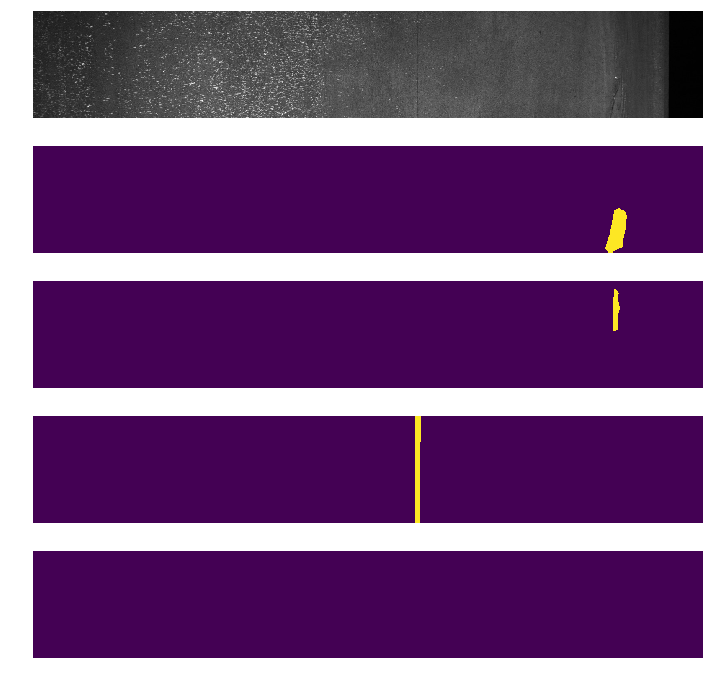

In [11]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = trset_df[trset_df['ImageId'] == sample_filename]
sample_path = f"train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

In [12]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [13]:
BATCH_SIZE = 48

train_idx, val_idx = train_test_split(
    trcount_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=trcount_df,
    target_df=trset_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=trcount_df,
    target_df=trset_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

# Unet Model

In [14]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

In [15]:
model = build_model((256, 1600, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

Ran the model in google colab as it took a very long time to train.

In [16]:
checkpoint = ModelCheckpoint(
    'model_proj.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=5
)

NameError: name 'model' is not defined

In [ ]:
#model.save('model_unet.h5')

In [16]:
model.load_weights('model_unet.h5')

# Evaluation on test data

In [18]:
# test_images = os.listdir("test_images/")
# loadedImages = []

# for img in test_images:
#         image = cv2.imread("test_images/"+img)
#         loadedImages.append(image)
# test_images = np.array(loadedImages)
# test_images.shape

In [19]:
sub_pre_df = pd.read_csv('sample_submission.csv')
sub_df = pd.DataFrame(index=range(0,4*len(sub_pre_df)), columns = ['ImageId','ClassId','EncodedPixels'])

for i in range(0,len(sub_pre_df)):
    for j in range(1,num_classes+1):
        idx = i * num_classes + j - 1
        sub_df.iloc[idx] = pd.Series({'ImageId':sub_pre_df.iloc[i]['ImageId'], 'ClassId':j})
#sub_df.head(100)

In [20]:
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [23]:
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    #print(batch_idx)

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='test_images/',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

500/500 [==============================] - 250s 499ms/step


500it [00:17, 27.98it/s]


500/500 [==============================] - 223s 447ms/step


500it [00:17, 29.08it/s]


500/500 [==============================] - 240s 479ms/step


500it [00:16, 29.42it/s]


500/500 [==============================] - 250s 499ms/step


500it [00:20, 24.75it/s]


500/500 [==============================] - 270s 540ms/step


500it [00:17, 27.80it/s]


500/500 [==============================] - 263s 526ms/step


500it [00:18, 26.46it/s]


500/500 [==============================] - 255s 510ms/step


500it [00:18, 27.49it/s]


500/500 [==============================] - 284s 568ms/step


500it [00:25, 19.61it/s]


500/500 [==============================] - 217s 435ms/step


500it [00:15, 31.63it/s]


500/500 [==============================] - 214s 428ms/step


500it [00:16, 29.99it/s]


500/500 [==============================] - 215s 430ms/step


500it [00:16, 29.95it/s]


6/6 [==============================] - 3s 442ms/step


6it [00:00, 57.32it/s]


In [26]:
test_f_df = pd.concat(test_df)
test_f_df.to_csv('submission_final.csv', index=False)

In [39]:
colors = np.array([[255,0,0],[0,255,0],[0,0,255],[255,255,0]])
colors.shape

(4, 3)

In [47]:
sample_filename = '0000f269f.jpg'
sample_image_df = test_f_df[test_f_df['ImageId'] == sample_filename]
sample_path = f"test_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

In [48]:
sample_masks.shape

(256, 1600, 4)

(-0.5, 1599.5, 255.5, -0.5)

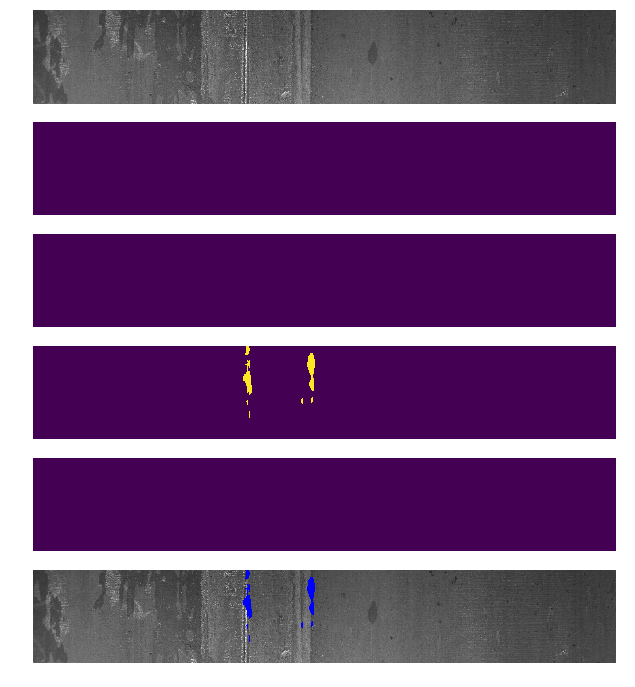

In [50]:
fig, axs = plt.subplots(6, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')
    for r in range(0,sample_masks.shape[0]):
        for c in range(0,sample_masks.shape[1]):
            if(sample_masks[r,c,i] > 0):
                sample_img[r,c,:] = colors[i,:]
axs[5].imshow(sample_img)
axs[5].axis('off')

In [95]:
def def_draw(filename,test_f_df,path,wr_path):
    sample_image_df = test_f_df[test_f_df['ImageId'] == filename]
    #sample_img = cv2.imread(path+filename)
    sample_rles = sample_image_df['EncodedPixels'].values
    sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
    indicesPerClass = [0,0,0,0]
    numClasses = 0
    for i in range(4):
        for r in range(0,sample_masks.shape[0]):
            for c in range(0,sample_masks.shape[1]):
                if(sample_masks[r,c,i] > 0):
                    sample_img[r,c,:] = colors[i,:]
                    indicesPerClass[i] = indicesPerClass[i] + 1
        if(indicesPerClass[i] > 0):
            numClasses = numClasses + 1
    print(filename,":",numClasses)
    cv2.imwrite(wr_path+filename, sample_img)  

Evaluating on the train images also as we have the golden labels to verify the predictions.

In [79]:
train_unique = train_df['ImageId'].unique()

In [89]:
for i in range(0,len(train_unique)):
    def_draw(train_unique[i],train_pred_daf,'train_images/','train_pred_images/')
    if i%500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [82]:
train_imgs_df = pd.DataFrame(train_df['ImageId'].unique(), columns=['ImageId'])

In [87]:
train_pred_df = []

for i in range(0, train_imgs_df.shape[0], 500):
    batch_idx = list(
        range(i, min(train_imgs_df.shape[0], i + 500))
    )
    #print(batch_idx)

    test_generator = DataGenerator(
        batch_idx,
        df=train_imgs_df,
        shuffle=False,
        mode='predict',
        base_path='train_images/',
        target_df=trset_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

    for j, b in tqdm(enumerate(batch_idx)):
        filename = train_imgs_df['ImageId'].iloc[b]
        image_df = trset_df[trset_df['ImageId'] == filename].copy()        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        image_df['EncodedPixels'] = pred_rles
        train_pred_df.append(image_df)

500/500 [==============================] - 225s 450ms/step


500it [00:16, 29.58it/s]


500/500 [==============================] - 223s 446ms/step


500it [00:17, 29.41it/s]


500/500 [==============================] - 226s 451ms/step


500it [00:19, 26.29it/s]


500/500 [==============================] - 216s 432ms/step


500it [00:18, 27.50it/s]


500/500 [==============================] - 216s 432ms/step


500it [00:17, 28.55it/s]


500/500 [==============================] - 217s 434ms/step


500it [00:17, 28.11it/s]


500/500 [==============================] - 223s 445ms/step


500it [00:17, 28.99it/s]


500/500 [==============================] - 216s 433ms/step


500it [00:17, 28.48it/s]


500/500 [==============================] - 215s 429ms/step


500it [00:17, 27.84it/s]


500/500 [==============================] - 215s 431ms/step


500it [00:17, 28.19it/s]


500/500 [==============================] - 213s 427ms/step


500it [00:17, 28.89it/s]


500/500 [==============================] - 213s 426ms/step


500it [00:17, 28.73it/s]


500/500 [==============================] - 212s 425ms/step


500it [00:17, 28.31it/s]


166/166 [==============================] - 70s 422ms/step


166it [00:03, 50.57it/s]


In [88]:
train_pred_daf = pd.concat(train_pred_df)
train_pred_daf.to_csv('submission_train_pred.csv', index=False)

(-0.5, 1599.5, 255.5, -0.5)

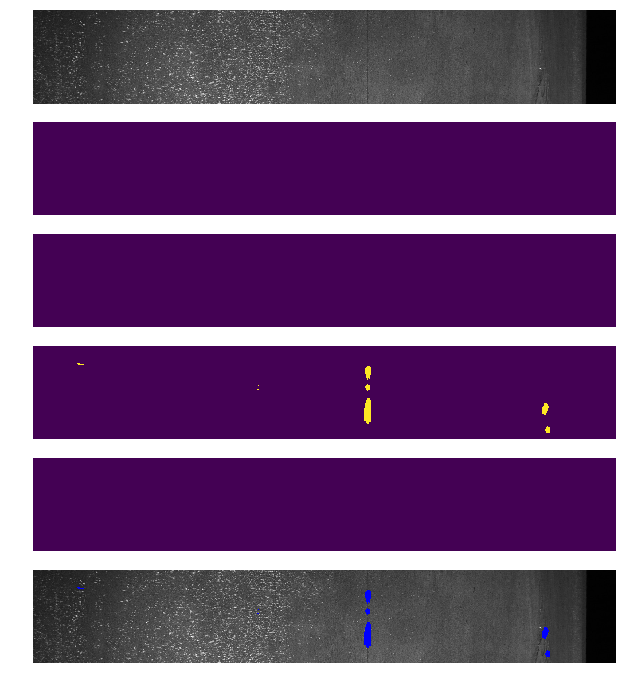

In [94]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_pred_daf[train_pred_daf['ImageId'] == sample_filename]
sample_path = f"train_images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(6, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')
    for r in range(0,sample_masks.shape[0]):
        for c in range(0,sample_masks.shape[1]):
            if(sample_masks[r,c,i] > 0):
                sample_img[r,c,:] = colors[i,:]
axs[5].imshow(sample_img)
axs[5].axis('off')

In [ ]:
for i in range(0,sub_pre_df.shape[0]):
    def_draw(sub_pre_df.iloc[i]['ImageId'],test_f_df,'test_images/','pred_images/')
    if i%500 == 0:
        print(i)